In [1]:
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps

import os

import keras
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.layers import *
from keras import optimizers, losses, activations, constraints, regularizers
import keras.backend as K
import tensorflow as tf

import cv2
from sklearn.metrics import f1_score, fbeta_score
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from skimage import exposure, filters
from skimage.morphology import disk, remove_small_objects
from skimage.filters import rank, threshold_isodata
from skimage.transform import resize
import skimage.io

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# from imgaug import augmenters as iaa
IMG_SIZE = 256
def processImage(image):
    if np.ptp(image) <= 2:
        image = image*255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    image = image/255.0 - 0.5
    img = np.reshape(image, (-1,3))
    mu, eig = cv2.PCACompute(img, np.empty((0)))
    img = np.dot(img - mu, eig.T)
    S = np.reshape(img, image.shape)
    S = S[:,:,0]
#     S = cv2.addWeighted ( S, 4, cv2.GaussianBlur( S , (0,0) , IMG_SIZE/10) ,-4 ,12)
    S = (S-np.min(S))/(np.max(S)-np.min(S))
    selem = disk(IMG_SIZE//72)
    T = rank.equalize(S, selem=selem)
    T = S*T/255
    J = exposure.equalize_adapthist(S, [IMG_SIZE//24,IMG_SIZE//24],nbins=256, clip_limit=0.01)*255
    Jf = cv2.GaussianBlur(J,(9,9),0)
    Z = Jf - J
    L = threshold_isodata(Z)
    Z = np.array(Z, dtype = np.uint8)
    ret, bw = cv2.threshold(Z, L, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    bwc = remove_small_objects(bw, min_size=(IMG_SIZE//24)**2, connectivity=4)
    oddSz = 2*(IMG_SIZE//48)-1
    bwc = cv2.GaussianBlur(bwc,(oddSz,oddSz),0)
    bwc = exposure.equalize_adapthist(S*bwc/255, nbins=256)
    img = np.concatenate([np.expand_dims(i, -1) for i in [bwc, S, T]], -1)
    return img

In [14]:
IMG_SIZE = 331
train_datagen = ImageDataGenerator(
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.1,
        fill_mode='constant', cval=0)

train_generator = train_datagen.flow_from_directory(
        'train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=8*3,
        class_mode='categorical', 
        subset='training')
val_generator = train_datagen.flow_from_directory(
        'train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=8*3,
        class_mode='categorical',
        subset='validation')

Found 34915 images belonging to 5 classes.
Found 3878 images belonging to 5 classes.


In [4]:
# import os
# from zipfile import ZipFile
# import pandas as pd
# from tqdm import tnrange, tqdm_notebook

# df = pd.read_csv('trainLabelsEyePacs.csv')
# df.head()

# with ZipFile('trainEyePacs.zip') as zipfile:
#     for i in tnrange(len(df)):
#         src_path = f'train/{df["image"][i]}.jpeg'
#         dest_path = fr'train/{df["level"][i]}/{df["image"][i]}.jpeg'
#         zipfile.extract(src_path, dest_path)

In [4]:
from keras.models import Model
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model = NASNetLarge(weights=None, include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
def quadratic_kappa_coefficient(y_true, y_pred, scale = 2):
    y_true = K.cast(y_true, "float32")
    n_classes = K.cast(y_pred.shape[-1], "float32")
    weights = K.arange(0, n_classes, dtype="float32") / (n_classes - 1)
    weights = (weights - K.expand_dims(weights, -1)) ** 2

    hist_true = K.sum(y_true, axis=0)
    hist_pred = K.sum(y_pred, axis=0)

    E = K.expand_dims(hist_true, axis=-1) * hist_pred
    E = E / K.sum(E, keepdims=False)

    O = K.transpose(K.transpose(y_true) @ y_pred)  # confusion matrix
    O = O / K.sum(O)

    num = weights * O
    den = weights * E

    QWK = (1 - K.sum(num) / K.sum(den))
    loss = -100*K.log(K.sigmoid(scale * QWK))
    return loss

In [6]:
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=quadratic_kappa_coefficient)

In [13]:
x,y = train_generator.__next__()

/home/monowar.a/anaconda3/envs/tf-cv2/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/monowar.a/anaconda3/envs/tf-cv2/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


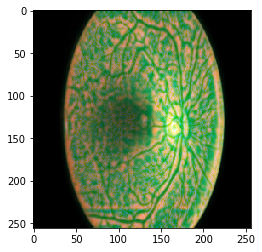

In [14]:
plt.imshow(x[0,:,:,:])

In [7]:
from keras.callbacks import ModelCheckpoint
filepath="NASNET_{epoch:02d}_{val_loss:.2f}.hdf5"
chkPnt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [ ]:
model.fit_generator(train_generator, 
                    steps_per_epoch=910, 
                    epochs=25, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=310, callbacks=[chkPnt])

Epoch 1/25


In [8]:
from keras.utils import multi_gpu_model
from keras.models import load_model
# model.load_weights('Xception_11_23.09.hdf5')
multi_model = multi_gpu_model(model, gpus=3)
multi_model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=quadratic_kappa_coefficient)

In [17]:
multi_model.fit_generator(train_generator, 
                    steps_per_epoch=1450, 
                    epochs=75, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=100, callbacks=[chkPnt])

Epoch 1/75
1450/1450 [==============================] - 3627s 3s/step - loss: 68.9441 - val_loss: 69.3147

Epoch 00001: val_loss improved from inf to 69.31472, saving model to NASNET_01_69.31.hdf5
Epoch 2/75
1450/1450 [==============================] - 3597s 2s/step - loss: 68.0917 - val_loss: 70.0095

Epoch 00002: val_loss did not improve from 69.31472
Epoch 3/75
1450/1450 [==============================] - 3582s 2s/step - loss: 69.3147 - val_loss: 69.3344

Epoch 00003: val_loss did not improve from 69.31472
Epoch 4/75
1450/1450 [==============================] - 3584s 2s/step - loss: 69.3149 - val_loss: 69.3149

Epoch 00004: val_loss did not improve from 69.31472
Epoch 5/75
1450/1450 [==============================] - 3593s 2s/step - loss: 69.3147 - val_loss: 69.3143

Epoch 00005: val_loss improved from 69.31472 to 69.31430, saving model to NASNET_05_69.31.hdf5
Epoch 6/75
1450/1450 [==============================] - 3583s 2s/step - loss: 69.3147 - val_loss: 69.3147

Epoch 00006: val_

KeyboardInterrupt: 